# Predicting Monkey Arm Movememnts via Electrode Signals

Import libraries

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from google.colab import drive
!pip install --upgrade tsmoothie
from tsmoothie.smoother import LowessSmoother

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Connect dataset from Google Drive

In [2]:
drive.mount('/content/drive')
path = "drive/MyDrive/CS230_Project/Jenkins_Rstruct_Data"
!ls $path

Mounted at /content/drive
JR_2015-12-04_truncated2.mat  plan_test_data.mat  plan_training_data.mat


## Dataset information

In [3]:
import scipy.io as sio
R = sio.loadmat(path+"/JR_2015-12-04_truncated2.mat")["R"][0]
ntrials = len(R)
shape = R[0]['spikeRaster'].todense().shape
fields = R[0].dtype.names

print("There are %d trials in the R-struct" % ntrials)
print("There are %d electrodes with %d millseconds of data \n" % (shape[0], shape[1]))
print("Fields in this dataset include: ")
for field in fields:
    print("-", field)

There are 506 trials in the R-struct
There are 96 electrodes with 901 millseconds of data 

Fields in this dataset include: 
- startDateNum
- startDateStr
- timeTargetOn
- timeTargetAcquire
- timeTargetHeld
- timeTrialEnd
- subject
- counter
- state
- cursorPos
- spikeRaster
- spikeRaster2
- isSuccessful
- trialNum
- timeFirstTargetAcquire
- timeLastTargetAcquire
- trialLength
- target


The fields we care about the most are `target` and `spikeRaster`.

The `target` field holds the coordinates of the reach direction of a given trial.
```python
# returns a tuple indicating the x, y, and z coordinates
# of the target reach direction for trial 0
R[0]['target']
```
The `spikeRaster` field holds a sparse matrix where each row corresponds to an electrode, and each column corresponds to a spike time. We will use the `.todense()` function to convert the row to an array of 1s and 0s where each index is a millisecond indicating whether a neuron fired (1) or not (0).
```python
# returns an array of spikes for the first trial and
# and the first electrode
R[0]['spikeRaster'].todense()[0, :]
# returns whether there was a spike for the first trial and
# and the first electrode during the 10th millisecond
R[0]['spikeRaster'].todense()[0,9]
```

There are 9 possible reach directions.
```python
# Targets sorted in CCW
xy_sorted = np.array([
             [0.0, 0.0],          # 0
             [120.0, 0.0],          # 1
             [84.85, 84.85],        # 2
             [0.0,   120.0],        # 3
             [-84.85,84.85],        # 4
             [-120.0, 0],           # 5
             [-84.85, -84.85],      # 6
             [0.0, -120],           # 7
             [84.85,-84.85]])       # 8
```

### Raster plot of the data

In [4]:
def plotRaster(S):
    """
    plotRaster:
    -----------
    - S: spike train
    -----------
    - creates a raster plot of the spikes
    """
    gap = 3
    mark = 5
    pad = 30
    numSpikeTrain = len(S);
    plt.figure()
    for s in range(numSpikeTrain):
        offset = pad + gap + s*(gap+mark);
        train = S[s]
        for t in train:
            plt.plot([t, t], [offset, offset+mark],'black')
        
    plt.xlabel('Time (ms)')
    plt.ylim([0,offset+mark+gap+pad])
    plt.yticks([])
    plt.grid(axis='x')

Text(0.5, 1.0, 'Raster Plot for Electrode 17')

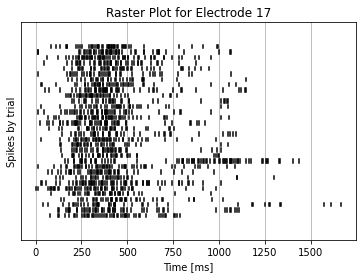

In [5]:
num_reaches = 32
electrode_number = 17
spike_train = np.zeros((num_reaches), dtype=object)
ix = 0
for trial in R:
    target = trial["target"]
    
    if (target[0]==120 and target[1] == 0):
        spike_train[ix] =  np.where(trial["spikeRaster"].todense()[electrode_number - 1,:])[1]
        ix += 1
    
plotRaster(spike_train);
plt.xlabel('Time [ms]')
plt.ylabel('Spikes by trial')
plt.title('Raster Plot for Electrode 17')

## Restructure the data

### Seperate data per reach, shift middle reaches, and apply pretraining

In [6]:
def seperate_reaches(R, n_reach_trials, num_electrodes, ms_start, ms, reaches, middle_reach={}, shift_middle=True):
    """
    seperate_reaches:
    -----------------
    - R: neural data
    - n_reach_trials: number of trials we care about
    - num_electrodes: number of electrodes we want to account for
    - ms_start: start index of timeseries spikes
    - ms: length of timeseries
    - reaches: dict of possible reach directions (should have length of 8 if shift_middle is True)
    - middle_reach: dict of mappings for shifting middle reaches
    - shift_middle: boolean indicating if we want to shift the middle
    -----------------
    - Seprates data by reach direction
    - Translates middle movements to reaches from previous point
    """
    if shift_middle and len(reaches) == 9:
        raise Exception("shift_middle is true which means len(reaches) should be 8")
    if not shift_middle and len(reaches) == 8:
        raise Exception("shift_middle is false which means len(reaches) should be 9")
    spike_times = np.ndarray(shape=(n_reach_trials, num_electrodes, ms))
    # pre training
    smoother = LowessSmoother(smooth_fraction=0.1, iterations=1)
    print(spike_times[0])
    smoother.smooth(spike_times[0])
    targets = np.ndarray(shape=(n_reach_trials, 1), dtype=int)

    count = {} # verify counts per reach
    per_reach = {} # seperate spikes per reach
    prev = (round(R[0]['target'][0].item(), 2), round(R[0]['target'][1].item(), 2))

    total = 0
    for n in range(n_reach_trials):
        spike_time = R[n]['spikeRaster'].todense()[:, ms_start: ms_start + ms]
        target_x = round(R[n]['target'][0].item(), 2)
        target_y = round(R[n]['target'][1].item(), 2)
        # first check if middle
        if target_x == round(0.0, 2) and target_y == round(0.0, 2) and shift_middle:
            target_x = round(middle_reach_dict[prev[0]], 2)
            target_y = round(middle_reach_dict[prev[1]], 2)
        for d, dir in enumerate(reaches):
            if target_x == round(dir[0], 2) and target_y == round(dir[1], 2):
                prev = (target_x, target_y)
                if d not in count:
                    count[d] = 0
                    per_reach[d] = []
                per_reach[d].append(spike_time)
                count[d] += 1
                # col[d] = 1
                targets[total, :] = d
                spike_times[total, :, :] = spike_time
                total += 1
                break
    return spike_times, targets, count, per_reach

In [7]:
n_reach_trials = ntrials - 1 # remove first middle reach
num_electrodes = 96
ms = 300
ms_start = 200

xy_sorted = np.array([
             [120.0, 0.0],
             [84.85, 84.85],
             [0.0, 120.0],
             [-84.85,84.85],
             [-120.0, 0],
             [-84.85, -84.85],
             [0.0, -120],
             [84.85,-84.85]])
xy_sorted_middle = np.array([
             [0.0, 0.0],
             [120.0, 0.0],
             [84.85, 84.85],
             [0.0, 120.0],
             [-84.85,84.85],
             [-120.0, 0],
             [-84.85, -84.85],
             [0.0, -120],
             [84.85,-84.85]])
middle_reach_dict = {
    0.0: 0.0,
    -84.85: 84.85,
    84.85: -84.85,
    -120.0: 120.0,
    120.0: -120.0,
}

In [8]:
spike_times, targets, count, per_reach = seperate_reaches(R, n_reach_trials, num_electrodes, ms_start, ms, xy_sorted, middle_reach_dict, shift_middle=True)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [9]:
spike_times.shape, targets.shape, count, len(per_reach) # verify

((505, 96, 300),
 (505, 1),
 {6: 63, 2: 63, 5: 62, 1: 62, 0: 64, 4: 64, 3: 63, 7: 63},
 8)

### Evenly Sample From Each Class

In [10]:
import sklearn.model_selection as sk

def even_sample(train_size, n_reach_trials, num_electrodes, ms, count, per_reach):
    # get num_train and num_test manually b/c of rounding errors
    num_train = 0
    num_test = 0
    for c in count:
        num_train += int(train_size * count[c])
        num_test += int((1 - train_size) * count[c])
    print(num_train, num_test, n_reach_trials - num_train)
    # initialize training and test sets
    X_train = np.ndarray(shape=(num_train, num_electrodes, ms))
    X_test = np.ndarray(shape=(n_reach_trials - num_train, num_electrodes, ms))
    Y_train = np.ndarray(shape=(num_train, 1), dtype=int)
    Y_test = np.ndarray(shape=(n_reach_trials - num_train, 1), dtype=int)

    train_start = 0
    test_start = 0
    test = 0
    train = 0
    for d in per_reach:
        reach = np.array(per_reach[d])
        target = np.full((reach.shape[0], 1), d)
        reach_x_train, reach_x_test, reach_y_train, reach_y_test = sk.train_test_split(reach, target, train_size=train_size, random_state = 42)
        train += len(reach_y_train)
        test += len(reach_y_test)
        X_train[train_start: train_start + reach_x_train.shape[0], :, :] = reach_x_train
        X_test[test_start: test_start + reach_x_test.shape[0], :, :] = reach_x_test
        Y_train[train_start: train_start + reach_y_train.shape[0], :] = reach_y_train
        Y_test[test_start: test_start + reach_y_test.shape[0], :] = reach_y_test
        train_start += reach_x_train.shape[0]
        test_start += reach_x_test.shape[0]
    return X_train, Y_train, X_test[:test], Y_test[:test]

In [11]:
raw_x_train, raw_y_train, raw_x_test, raw_y_test = even_sample(.7, n_reach_trials, num_electrodes, ms, count, per_reach)

350 146 155


In [12]:
raw_x_train.shape

(350, 96, 300)

### Reshape data and apply one-hot

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.initializers import glorot_uniform
import tensorflow as tf


In [14]:
from copy import deepcopy
X_train_base = tf.cast(deepcopy(raw_x_train), tf.float32)
X_test_base = tf.cast(deepcopy(raw_x_test), tf.float32)

In [15]:
X_train = tf.reshape(raw_x_train, (raw_x_train.shape[0], raw_x_train.shape[2], raw_x_train.shape[1]))
X_test = tf.reshape(raw_x_test, (raw_x_test.shape[0], raw_x_test.shape[2], raw_x_test.shape[1]))
X_train = tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)

In [16]:
Y_train = []
for t in range(raw_y_train.shape[0]):
    col = np.zeros((len(per_reach),))
    col[raw_y_train[t][0]] = 1
    Y_train.append(col)
Y_train = np.array(Y_train)

Y_test = []
for t in range(raw_y_test.shape[0]):
    col = np.zeros((len(per_reach),))
    col[raw_y_test[t][0]] = 1
    Y_test.append(col)
Y_test = np.array(Y_test)

Y_train.shape, Y_test.shape

((350, 8), (154, 8))

In [17]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

(TensorShape([350, 300, 96]), (350, 8), TensorShape([154, 300, 96]), (154, 8))

In [18]:
Y_train_base = deepcopy(Y_train)
Y_test_base = deepcopy(Y_test)

In [19]:
X_train_base.shape, Y_train_base.shape, X_test_base.shape, Y_test_base.shape

(TensorShape([350, 96, 300]), (350, 8), TensorShape([154, 96, 300]), (154, 8))

### Metric functions

In [20]:
def recall(y_true, y_pred):
    y_true = np.ones_like(y_true)
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    all_positives = np.sum(np.round(np.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + np.finfo(float).eps)
    return recall

def precision(y_true, y_pred):
    y_true = np.ones_like(y_true)
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    predicted_positives = np.sum(np.round(np.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + np.finfo(float).eps)
    return precision

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2*((p*r)/(p+r+np.finfo(float).eps))

## Base Model

In [21]:
def Base(input_shape):
    """
    Dense -> Dense -> Dense -> Softmax
    Arguments:
    input_shape    -- shape of the input, usually (max_len,)
    num_catagories -- number of catagories (8 or 9)
    Returns:
    model -- a model instance in Keras
    """

    input = Input(input_shape, dtype='float32')
    X = Flatten()(input)
    print(X.shape)
    X = Dense(40)(X) 
    X = Dense(12)(X) 
    X = Dense(8)(X) 
    X = Activation('softmax')(X)
    
    model = Model(input, X)
    
    
    return model

### Training

In [22]:
model = Base((num_electrodes, ms))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


(None, 28800)


In [23]:
model.fit(X_train_base, Y_train_base, epochs=2, batch_size = 1, shuffle=True, verbose=1)

Epoch 1/2
350/350 [==============================] - 6s 13ms/step - loss: 2.0277 - accuracy: 0.2629
Epoch 2/2
350/350 [==============================] - 4s 12ms/step - loss: 0.0445 - accuracy: 0.9914


In [24]:
loss, acc = model.evaluate(X_test_base, Y_test_base)
print("Test accuracy = ", acc)

5/5 [==============================] - 1s 8ms/step - loss: 1.7658 - accuracy: 0.3182
Test accuracy =  0.3181818127632141


In [25]:
# verify test
preds = model.predict(X_test_base)


5/5 [==============================] - 0s 7ms/step


In [26]:
m = tf.keras.metrics.top_k_categorical_accuracy(Y_test_base, preds, k=3)
np.sum(m) / len(m)

0.7337662337662337

In [27]:
# from tensorflow.keras.metrics import confusion_matrix
conf = tf.compat.v1.confusion_matrix(np.argmax(Y_test_base, axis=1), np.argmax(preds, axis=1), num_classes=len(per_reach))

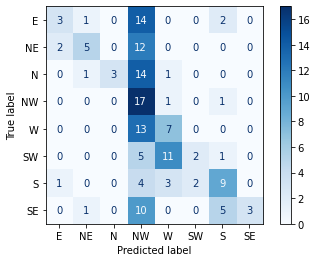

In [28]:
from sklearn.metrics import ConfusionMatrixDisplay

labels = ["E", "NE", "N", "NW", "W", "SW", "S", "SE"]

# recall 
disp = ConfusionMatrixDisplay(confusion_matrix=np.array(conf), display_labels=labels)

disp.plot(cmap=plt.cm.Blues)

Precision per class:  [0.5        0.625      1.         0.19101124 0.30434783 0.5
 0.5        1.        ]
Overall Precision:  0.3181818181818182
f1 score:  0.3181818181818182


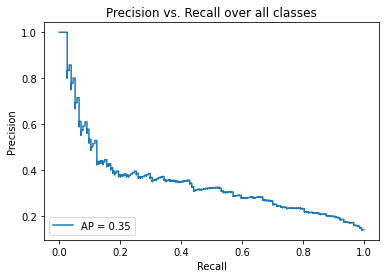

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, precision_score, precision_recall_curve, average_precision_score, PrecisionRecallDisplay, f1_score


# percision
print("Precision per class: ", precision_score(np.argmax(Y_test_base, axis=1), np.argmax(preds, axis=1), average=None, sample_weight=None, zero_division='warn'))
print("Overall Precision: ", precision_score(np.argmax(Y_test_base, axis=1), np.argmax(preds, axis=1), average='micro', sample_weight=None, zero_division='warn'))

# recall and precision score
precision = dict()
recall = dict()
average_precision = dict()
for i in range(len(labels) - 1):
    precision[i], recall[i], _ = precision_recall_curve(Y_test_base[:, i], preds[:, i])
    average_precision[i] = average_precision_score(Y_test_base[:, i], preds[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test_base.ravel(), preds.ravel()
)
average_precision["micro"] = average_precision_score(Y_test_base, preds, average="micro")
display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Precision vs. Recall over all classes")

# f1 score
print("f1 score: ", f1_score(np.argmax(Y_test_base, axis=1), np.argmax(preds, axis=1), labels=None, pos_label=1, average='micro', sample_weight=None, zero_division='warn'))